# Introduction - theory

The Gaussian and the bilateral filters are two techniques used to blur images. The bilateral filter has the advantages of respecting strong edges (cf. figure below)
![](lapin.jpg)
Bluring is the simplest way of smoothing an image. In this project the Gaussian filter is defined as 

$$ C_{i,j} = \sum_{m=0}^{2 l_w} \sum_{n=0}^{2 lw} K_{m,n} \, I_{i-lw + m, j-l_w+n},$$

where $C_{i,j}$ is the filtered image. $i$ and $j$ are the indices of the pixels in the image, K_{m,n} is the Gaussian Kernel and $I_{i,j}$ is the input image. The Gaussian kernel is defined as

$$ K_{m,n} = \frac{1}{\sqrt{2 \pi \sigma} }  \exp \left( \frac{||(m,n) - (i,j)||_2}{2 \sigma^2}  \right)$$.


Gaussian filtering is a weighted average of the intensity of the adjacent positions with a weight decreasing with the spatial distance to the center position. The bilateral filter is also defined as a weighted average of adjacnet pixels, in a similar fashion to the Gaussian convolution. One key difference is that the bilateral filter accounts for the difference in value with the neighbors to preserve edges while smoothing. The concept of the bilateral filter is that for a pixel to influence another pixel, it should not only occupy a close by location but also have a similar value. The filtered image is defined as

$$I^\text{filtered}(x) = \frac{1}{W_p} \sum_{x_i \in \Omega} I(x_i)f_r(\|I(x_i)-I(x)\|)g_s(\|x_i-x\|)$$

This equation is a normalized weighted average where $g_s$ is a spatial Gaussian weighting that decreases the influence of distant pixels and $f_r$ is a range Gaussian that decreases the influence of pixels $x_i$ when their intensity values differ from $I(x)$.

# Gaussian filter

Here we implement most of the previously developped parallelized algorithm to the simple Gaussian filter. In this case the filtered image satisfies the convolution

$$ C_{i,j} = \sum_{m=0}^{2 l_w} \sum_{n=0}^{2 lw} K_{m,n} \, I_{i-lw + m, j-l_w+n},$$

where $C_{i,j}$ is the filtered image. $i$ and $j$ are the indices of the pixels in the image, K_{m,n} is the Gaussian Kernel and $I_{i,j}$ is the input image. The Gaussian kernel is defined as

$$ K_{m,n} = \frac{1}{\sqrt{2 \pi \sigma} }  \exp \left( \frac{||(m,n) - (i,j)||_2}{2 \sigma^2}  \right)$$

The purpose of this section is to compare our implementation to the scipy implementation.

Here is the class we developped that allows to apply a Gaussian filter with various implementation. We first take the image and pad it with various methods that are already implemented in scipy: reflect, nearest, constant and wrap. In this case the kernel can be precomputed before defining the window. The kernel will be the same for every pixel -- this is different from the bilateral filter implementation. Here we have 4 different implementations. They all loop over $i$ and $j$ in serial. For each pixel, the window is assembled. The size of the window is [2* lw + 1, 2* lw + 1]. The convolution of the window with the kernel is implemented in 4 different ways: 1/ a simple python implementation of the convolution using numpy.sum(window*kernel) called by the method __filter_python__. 2/ a cython implementation of the convolution using a "prange" for the loop over the rows called __filter_cython__. 3/ an AVX implementation following the procedure shown in this figure.

In [9]:
from IPython.display import HTML 
HTML('<img src="./fig6.png" width=800 height=800/>') 

For each row, AVX loads 8 adjacent pixels of 32 bits of window and kernel. The middle column is not loaded. The loop over the rows in done using a prange. The method is called __filter_AVX__ 4/ a multithreaded implementation. Each thread is takes care of one row of the input image. Thread 1 takes care of the first row, thread 2 takes care of the 2nd row, thread 3 of the 3r row, thread 4 of the 4th row and then thread 1 continues with row 5th etc (see figure below). The function is called __filter_cython_threading__.

In [12]:
HTML('<img src="./fig3.png" width=400 height=400/>') 

The code is shown in the cell below but won't run because of AVX implementation not supported in ipython notebook.

In [6]:
'''
Here is the class Gaussianfilter2D

''' 
class Gaussianfilter2D():
    '''
    2D gaussian filter on Black and White images

    The filter image satisfies the relation
    $$ C_{i,j} = \sum_{m=0}^{2 l_w} \sum_{n=0}^{2 lw} = K_{m,n} \, I_{i-lw + m, j-l_w+n}$$
    where C is the new image, K the gaussian kernel and I the original image

    Parameters

    ----------

    sigma : float

        standard deviation for the gaussian filter

    truncate : float, optional

        truncate the filter at this many standard deviations
        Default is 4.0


    mode : here are the various mode supported by the class

    mode       |   Ext   |         Input          |   Ext
    -----------+---------+------------------------+---------
    'reflect'  | 3  2  1 | 1  2  3  4  5  6  7  8 | 8  7  6 
    'nearest'  | 1  1  1 | 1  2  3  4  5  6  7  8 | 8  8  8
    'constant' | 0  0  0 | 1  2  3  4  5  6  7  8 | 0  0  0
    'wrap'     | 6  7  8 | 1  2  3  4  5  6  7  8 | 1  2  3    


    Attributes

    ----------   

    kernel_ : 2d-array

        this is the 2D gaussian filter kernel used in the convolution
        with the provided image

    image_benchmark_: 2d-array

        this is the image filtered with the 2D gaussian filter provided
        by the scipy library

    run_time_benchmark_: float

        this is the run time of the 2D gaussian filter provied by the
        scipy library

    image_: 2d-array

        this is the image filtered by the 2D gaussian filter implemented in 
        python

    run_time_: float

        this is the run time of the 2D gaussian filter implemented in python

    error_ : float

        this is the norm-2 error of the python function compared with the scipy
        function

    '''
    def __init__(self, sigma, truncate = 4.0 , mode = 'reflect', cval = 0.0,
                    num_threads = 4):


        self.sigma = sigma
        self.truncate = truncate
        self.mode = mode
        self.cval = cval
        self.num_threads = num_threads


        # lw is the number of adjacent pixels on both sides to consider in 1D
        # when using the filter 
        self.lw = int(truncate*sigma+0.5)   


    @property
    # this is read only
    def kernel_(self):

        '''
        this function generates the Gaussianfilter2D kernel
        '''

        # initialize the size of the gaussian kernel
        # kernel size: pan * pan (33 * 33 when truncate = 4.0 and sigma = 4.0)
        self._kernel = np.zeros((2 * self.lw + 1,2 * self.lw +1 ))

        # find the distance to the center of all pixels in the kernel
        for i in range(0,self.lw+1):
            for j in range(0,self.lw+1):
                # pixel at the center the distance is 0
                if i == 0 and j ==0:
                    self._kernel[self.lw,self.lw] = 0
                # the other pixels in the kernel
                else:
                    self._kernel[i+self.lw,j+self.lw] = np.linalg.norm([i,j])**2
                    self._kernel[-i+self.lw,-j+self.lw] = np.linalg.norm([i,j])**2
                    self._kernel[-i+self.lw,j+self.lw] = np.linalg.norm([i,j])**2
                    self._kernel[i+self.lw,-j+self.lw] = np.linalg.norm([i,j])**2
                
        # compute the gaussian kernel
        self._kernel *= -.5/self.sigma**2
        self._kernel = np.exp(self._kernel)
        self._kernel /= 2*np.pi * self.sigma**2
        self._kernel /= np.sum(self._kernel)

        return self._kernel

    def filter_scipy(self, f ):
        start = time.time()
        self.image_benchmark_ = gaussian_filter(f,self.sigma , mode = self.mode, cval = self.cval )
        self.run_time_benchmark_ = time.time() - start
        return self.image_benchmark_, self.run_time_benchmark_

    def _python_convolution(self, lx, ly, image):

        # convolution with the gaussian kernel for filtering
        for i in range(0 , lx ):
            for j in range(0 , ly ):
                window = image[i : i + 2*self.lw + 1, j: j + 2*self.lw + 1]
                self.image_[i , j]= np.sum(window*self._kernel)
        return self.image_

    def _return_cython_convolution(self, lx, ly, image):

        # convolution using the Gaussian kernel

        # initialize for cython
        image_in = np.array(image, dtype = np.float32)
        image_out = np.zeros((lx,ly), dtype = np.float32)
        kernel = np.array(self._kernel, dtype = np.float32)
        _cython_convolution(self.lw, lx, ly, image_in, image_out, kernel, self.num_threads)

        self.image_ = image_out

        return self.image_  

        
    def _return_AVX_cython_convolution(self, lx, ly, image):

        # convolution using the Gaussian kernel

        # initialize for cython
        image_in = np.array(image, dtype = np.float32)
        image_out = np.zeros((lx,ly), dtype = np.float32)
        kernel = np.array(self._kernel, dtype = np.float32)
        _AVX_cython_convolution(self.lw, lx, ly, image_in, image_out, kernel, self.num_threads)

        self.image_ = image_out

        return self.image_

    def filter_AVX(self,f):


        start = time.time()
        self.image_ = f * 0.0
        lx, ly = f.shape
        # create the gaussian filter kernel
        self._kernel = self.kernel_

        # implement the different type of method to treat the edges
        image = self._padding(f)

        # convolution with the gaussian kernel for filtering
        self.image_= self._return_AVX_cython_convolution(lx,ly,image)

        self.run_time_ = time.time() - start

        # run the filter with scipy to get error and run time difference
        self.filter_scipy(f)
        self.error_ = np.linalg.norm(self.image_benchmark_-self.image_)

        # run time is normalized by the run time of the scipy library
        self.run_time_ /= self.run_time_benchmark_

        return self     

    def filter_cython(self,f):


        start = time.time()
        self.image_ = f * 0.0
        lx, ly = f.shape
        # create the gaussian filter kernel
        self._kernel = self.kernel_

        # implement the different type of method to treat the edges
        image = self._padding(f)

        # convolution with the gaussian kernel for filtering
        self.image_= self._return_cython_convolution(lx,ly,image)

        self.run_time_ = time.time() - start

        # run the filter with scipy to get error and run time difference
        self.filter_scipy(f)
        self.error_ = np.linalg.norm(self.image_benchmark_-self.image_)

        # run time is normalized by the run time of the scipy library
        self.run_time_ /= self.run_time_benchmark_

        return self 

    def filter_python(self,f):


        start = time.time()
        self.image_ = f * 0.0
        lx, ly = f.shape
        # create the gaussian filter kernel
        self._kernel = self.kernel_

        # implement the different type of method to treat the edges
        image = self._padding(f)

        # convolution with the gaussian kernel for filtering
        self.image_= self._python_convolution(lx,ly,image)

        self.run_time_ = time.time() - start

        # run the filter with scipy to get error and run time difference
        self.filter_scipy(f)
        self.error_ = np.linalg.norm(self.image_benchmark_-self.image_)

        # run time is normalized by the run time of the scipy library
        self.run_time_ /= self.run_time_benchmark_

        return self

    def _padding(self, f):
        
        # implement the different type of method to treat the edges

        if self.mode == 'constant':

            # padding using the scipy library
            image = np.lib.pad(f , self.lw, 'constant', constant_values = self.cval)    

        elif self.mode == 'reflect':

            # padding using the scipy library
            image = np.lib.pad(f , self.lw, 'reflect')


        elif self.mode == 'wrap':

            # padding using the scipy library
            image = np.lib.pad(f , self.lw, 'wrap')

        elif self.mode == 'nearest':    

            # padding using the scipy library
            image = np.lib.pad(f , self.lw, 'edge')

        return image



def filter_cython_threading(gb, f):

    start = time.time()
    gb.image_ = f * 0.0
    lx, ly = f.shape
    # create the gaussian filter kernel
    gb._kernel = gb.kernel_

    # implement the different type of method to treat the edges
    image = gb._padding(f)

    # convolution with the gaussian kernel for filtering
    gb.image_= _return_cython_convolution_threading(gb.lw,lx,ly,image,gb._kernel,gb.num_threads)

    gb.run_time_ = time.time() - start

    # run the filter with scipy to get error and run time difference
    gb.filter_scipy(f)
    gb.error_ = np.linalg.norm(gb.image_benchmark_-gb.image_)

    # run time is normalized by the run time of the scipy library
    gb.run_time_ /= gb.run_time_benchmark_

    return gb   

def _return_cython_convolution_threading(lw,lx, ly, image,kernel,num_threads):

    # convolution using the Gaussian kernel

    # initialize for cython
    image_in = np.array(image, dtype = np.float32)
    image_out = np.zeros((lx,ly), dtype = np.float32)
    kernel = np.array(kernel, dtype = np.float32)

    # # Create a list of threads
    threads = []
    for thread_id in range(num_threads):
        # t = threading.Thread(target = filter_threading, args = (image_out,thread_id))
        t = threading.Thread(target = filter_threading,
                            args = (lw, lx, ly, image_in, image_out, kernel, 
                                    thread_id,num_threads))
        threads.append(t)
        t.start()
    # make sure all the threads are done
    [t.join() for t in threads]

    return image_out        

def filter_threading(lw, lx, ly, image_in,image_out,kernel,thread_id, num_threads):
    # print('thread_id {}: image_out before= {} '.format(thread_id,image_out[0,0]))
    assert np.all(image_out[thread_id,:] == 0)
    _cython_convolution_threading(lw, lx, ly, image_in,image_out,kernel,thread_id, num_threads)
    # print('thread_id {}: image_in after= {} , image_out after= {} '
    #   .format(thread_id,image_in[thread_id+ num_threads,-8::],image_out[thread_id+ num_threads,-8::]))
    return image_out 

'''
These are the cython functions called by the class Gaussianfilter2D

'''


# cython decorators
@cython.boundscheck(False)
@cython.wraparound(False)

cpdef _AVX_cython_convolution(int lw,
                                int lx,
                                int ly,
                                np.float32_t [:,:] image_in,
                                np.float32_t [:,:] image_out,
                                np.float32_t [:,:] kernel,
                                int num_threads ):
    '''
    this function does the convolution for the Gaussian filter in 2D
    the function is written in cython for paralellizing the loops and 
    also uses AVX for the convolution. 

    Parameters

    ----------

    lw : int 

        number of adjacent pixels to considers on each sides 
        of the pixel that is being filtered

    lx, ly : int, int

        size of the image (lx, ly)

    image_in, image_out: np.float32_t

        the input image to be filtered and the resulting image filtered

    kernel: np.float32_t

        the 2D Gaussian kernel used for convolution

    num_threads: int

        the number of threads used for paralellization

    '''

    cdef:
        int i,j, i_local, k, m_8, n_elem, ii, jj
        np.float32_t [:,:] window
        np.float32_t [:] output_array_left,output_array_right, \
                            output_array_top, output_array_bot
        AVX.float8 AVX_coef_left, kernel_AVX_left, window_AVX_left, \
                            AVX_coef_right, kernel_AVX_right, window_AVX_right,\
                            AVX_coef_top, kernel_AVX_top , window_AVX_top, \
                            AVX_coef_bot, kernel_AVX_bot, window_AVX_bot
        float sumg , check_sum_manual
        int j_m

    # Find the modulus of the number of adjacent pixels 
    # note we assume that lw % 8 = 0 in this version of the code
    n_elem = lw / 8

    # loop over i and j to filter all the pixels
    window = np.zeros((2 * lw + 1, 2 * lw + 1), dtype = np.float32)
    for i in range(lx):
    # for i in prange(lx, \
    #           nogil=True, schedule = 'static', chunksize =1, num_threads= num_threads):   
        for j in range(ly):
        # for j in prange(ly, \
        #           nogil=True, schedule = 'static', chunksize =1, num_threads= num_threads):   

            # For one pixel, we proceed here to the convolution
            # i.e. np.sum(kernel * window)          

            # initialize summation 
            sumg = 0.0

            # define the image window used for the convolution with the kernel
            # for ii in range(2*lw +1):
            #   for jj in range(2 *lw +1):
            #       window[ii,jj] = image_in[i + ii,j + jj]

            window = image_in[i : i + 2*lw + 1, j: j + 2*lw + 1]

            # Doing the convolution with a first loop on the rows
            # We use AVX 8 float vectors to loop over the columns
            # i.e. multiplication and addition of 8 adjacent columns of 
            # kernel and window at a time

            # for i_local in range(window.shape[0]):
            for i_local in prange(window.shape[0], \
                nogil=True, schedule = 'static', chunksize =1, num_threads= num_threads):   
                for m_8 in range(n_elem):


                    # The pixel in the middle is at (i_local,lw)
                    # here we sum the left part
                    window_AVX_left = AVX.make_float8(window[i_local,m_8*8+7],
                                                     window[i_local,m_8*8+ 6],
                                                     window[i_local,m_8*8+ 5],
                                                     window[i_local,m_8*8+ 4],
                                                     window[i_local,m_8*8+ 3],
                                                     window[i_local,m_8*8+ 2],
                                                     window[i_local,m_8*8+ 1],
                                                     window[i_local,m_8*8+ 0])
                    kernel_AVX_left =  AVX.make_float8(kernel[i_local,m_8*8+7],
                                             kernel[i_local,m_8*8+6],
                                             kernel[i_local,m_8*8+5],
                                             kernel[i_local,m_8*8+4],
                                             kernel[i_local,m_8*8+3],
                                             kernel[i_local,m_8*8+2],
                                             kernel[i_local,m_8*8+1],
                                             kernel[i_local,m_8*8+0])
                    AVX_coef_left = AVX.mul(window_AVX_left,kernel_AVX_left)

                    # right part
                    window_AVX_right = AVX.make_float8(window[i_local,lw+1+m_8*8+ 7],
                                                     window[i_local, lw+1+ m_8*8+6],
                                                     window[i_local, lw+1+ m_8*8+5],
                                                     window[i_local, lw+1+ m_8*8+4],
                                                     window[i_local, lw+1+ m_8*8+3],
                                                     window[i_local, lw+1+ m_8*8+2],
                                                     window[i_local, lw+1+ m_8*8+1],
                                                     window[i_local,lw+1+  m_8*8+0])
                    kernel_AVX_right =  AVX.make_float8(kernel[i_local,lw+1+m_8*8+7],
                                             kernel[i_local,lw+1+m_8*8+6],
                                             kernel[i_local,lw+1+m_8*8+5],
                                             kernel[i_local,lw+1+m_8*8+4],
                                             kernel[i_local,lw+1+m_8*8+3],
                                             kernel[i_local,lw+1+m_8*8+2],
                                             kernel[i_local,lw+1+m_8*8+1],
                                             kernel[i_local,lw+1+m_8*8+0])
                    AVX_coef_right = AVX.mul(window_AVX_right,kernel_AVX_right) 

                    # summation of the 8 floats in AVX
                    for k in range(8):
                        sumg += <np.float32_t> (<np.float32_t *> &AVX_coef_left)[k]
                        sumg += <np.float32_t> (<np.float32_t *> &AVX_coef_right)[k]
                

            # Now we consider the column in the middle (:, lw)
            # we can multipliate and add after storing into AVX vectors
            # top and bottom
            window_AVX_top = AVX.make_float8(window[m_8*8+ 7, lw],
                                             window[ m_8*8+6, lw],
                                             window[ m_8*8+5, lw],
                                             window[ m_8*8+4, lw],
                                             window[ m_8*8+3, lw],
                                             window[ m_8*8+2, lw],
                                             window[ m_8*8+1, lw],
                                             window[ m_8*8+0, lw])
            kernel_AVX_top =  AVX.make_float8(kernel[m_8*8+7, lw],
                                     kernel[m_8*8+6, lw],
                                     kernel[m_8*8+5, lw],
                                     kernel[m_8*8+4, lw],
                                     kernel[m_8*8+3, lw],
                                     kernel[m_8*8+2, lw],
                                     kernel[m_8*8+1, lw],
                                     kernel[m_8*8+0, lw])
            AVX_coef_top = AVX.mul(window_AVX_top,kernel_AVX_top)   

            window_AVX_bot = AVX.make_float8(window[lw+1+ m_8*8+7, lw],
                                             window[ lw+1+ m_8*8+6, lw],
                                             window[ lw+1+ m_8*8+5, lw],
                                             window[ lw+1+ m_8*8+4, lw],
                                             window[ lw+1+ m_8*8+3, lw],
                                             window[ lw+1+ m_8*8+2, lw],
                                             window[ lw+1+ m_8*8+1, lw],
                                             window[lw+1+  m_8*8+0, lw])
            kernel_AVX_bot =  AVX.make_float8(kernel[lw+1+m_8*8+7, lw],
                                     kernel[lw+1+m_8*8+6, lw],
                                     kernel[lw+1+m_8*8+5, lw],
                                     kernel[lw+1+m_8*8+4, lw],
                                     kernel[lw+1+m_8*8+3, lw],
                                     kernel[lw+1+m_8*8+2, lw],
                                     kernel[lw+1+m_8*8+1, lw],
                                     kernel[lw+1+ m_8*8+0, lw])
            AVX_coef_bot = AVX.mul(window_AVX_bot,kernel_AVX_bot)


            for k in range(8):
                sumg += <np.float32_t> (<np.float32_t *> &AVX_coef_top)[k]
                sumg += <np.float32_t> (<np.float32_t *> &AVX_coef_bot)[k]

            # add the middle one
            sumg += kernel[lw,lw]*window[lw,lw]                                     

            # compute the filtered image
            image_out[i, j] = sumg

# cython decorators
@cython.boundscheck(False)
@cython.wraparound(False)

cdef _cython_convolution(int lw,
                        int  lx,
                        int  ly,
                        np.float32_t [:,:] image_in,
                        np.float32_t [:,:] image_out,
                        np.float32_t [:,:] kernel,
                        int num_threads):

    cdef:
        int i, j, i_local, j_local
        np.float32_t [:,:] window
        float sumg

    # convolution with the gaussian kernel for filtering
    for i in range(0 , lx ):
        for j in range(0 , ly ):
            window = image_in[i : i + 2* lw + 1, j: j + 2* lw + 1]
            sumg = 0.0
            # for i_local in range(window.shape[0]):
            for i_local in prange(window.shape[0], \
                nogil=True, schedule = 'static', num_threads= num_threads):
                for j_local in range(window.shape[1]):
                    sumg += window[i_local, j_local]*kernel[i_local,j_local]
            image_out[i, j] = sumg
            
@cython.boundscheck(False)
@cython.wraparound(False)
cdef filter_threading_2(np.float32_t [:,:] image_out,int thread_id):
    image_out[0,0] += 1

# cython decorators
@cython.boundscheck(False)
@cython.wraparound(False)
cdef _cython_convolution_threading(int lw,
                        int  lx,
                        int  ly,
                        np.float32_t [:,:] image_in,
                        np.float32_t [:,:] image_out,
                        np.float32_t [:,:] kernel,
                        int offset,
                        unsigned int step):
    cdef:
        int i, j, i_local, j_local
        np.float32_t [:,:] window
        float sumg

    # # convolution with the gaussian kernel for filtering
    with nogil:
        i = offset
        while i < lx :
            for j in range(0, ly):
                window = image_in[i : i +2* lw+ 1, j: j + 2* lw + 1]
                sumg = 0.0
                for i_local in range(window.shape[0]):
                    for j_local in range(window.shape[1]):
                        sumg += window[i_local, j_local]*kernel[i_local,j_local]
                image_out[i, j] = sumg
            i += step

In [25]:
# ------------------------------------------------------------
# import modules to compile cython and AVX
# ------------------------------------------------------------
%matplotlib inline
import sys
import os.path
sys.path.append(os.path.join('.', 'util'))

import set_compiler
set_compiler.install()

import pyximport
pyximport.install()
import pdb


from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
from Gaussianfilter2D_class import Gaussianfilter2D, filter_cython_threading

# --------------------------------------------
# initialization - define image
# --------------------------------------------*
imagename = 'test.png'

# load image (only one color now)
f = misc.imread(imagename)
if imagename == 'small.png':
    f = f[:,:,0]
else:
    pass


# --------------------------------------------
# Gaussian filter
# --------------------------------------------

# create a instance gaussian filter
gb = Gaussianfilter2D(sigma = 8.0, truncate = 8.0, mode = 'reflect', cval = 0.0, num_threads = 4)


# --------------------------------------------
# print the run times
# --------------------------------------------

gb.filter_python(f)
print('run time python = {} * run time scipy'.format(gb.run_time_))

gb.filter_cython(f)
print('run time cython = {} * run time scipy'.format(gb.run_time_))

gb.filter_AVX(f)
print('run time AVX = {} * run time scipy'.format(gb.run_time_))

filter_cython_threading(gb,f)
print('run time cython with multithreading = {} * run time scipy'.format(gb.run_time_))


Compiling with /usr/local/bin/clang-omp
run time python = 711.942911829 * run time scipy
run time cython = 315.864271292 * run time scipy
run time AVX = 468.0083236 * run time scipy
run time cython with multithreading = 141.307194282 * run time scipy


Here we show the image that has been filtered.

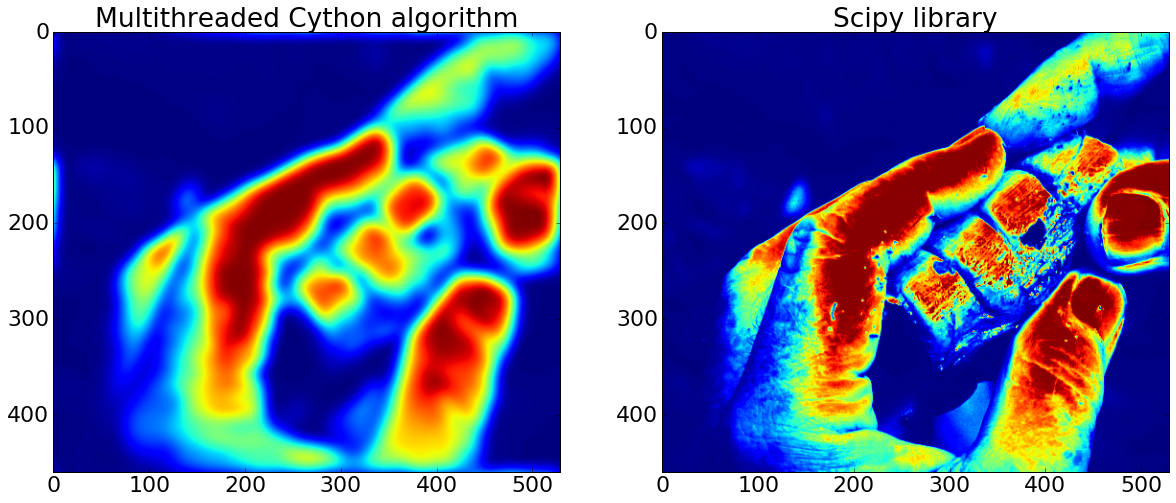

In [20]:
# # --------------------------------------------
# # plot the images
# # --------------------------------------------
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(gb.image_);
ax[0].set_title('Multithreaded Cython algorithm');
ax[1].imshow(f);
ax[1].set_title('Scipy library');
plt.show()

Let us compare the run time for various values of truncate.

In [41]:
time_python = []
time_cython = []
time_AVX = []
time_threading = []

truncate_vector = [4,8,12,16,20]
for trunc in truncate_vector:
    # create a instance gaussian filter
    gb = Gaussianfilter2D(sigma = 8.0, truncate = trunc, mode = 'reflect', cval = 0.0, num_threads = 4)
    gb.filter_python(f)
    time_python.append(gb.run_time_)
    gb.filter_cython(f)
    time_cython.append(gb.run_time_)
    gb.filter_AVX(f)
    time_AVX.append(gb.run_time_)
    filter_cython_threading(gb,f)
    time_threading.append(gb.run_time_)

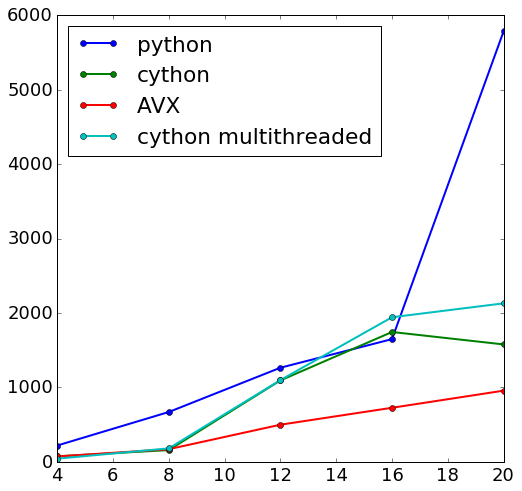

In [49]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,8))
plt.plot(truncate_vector,time_python, 'o-',lw =2,label ='python')
plt.plot(truncate_vector,time_cython, 'o-',lw =2,label='cython')
plt.plot(truncate_vector, time_AVX, 'o-',lw =2,label ='AVX')
plt.plot(truncate_vector,time_threading, 'o-',lw =2,label='cython multithreaded')
plt.legend(loc='best')